In [1]:
# XGBoost try on CNY data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
dset = pd.read_csv('dset.csv', sep = ';')
dset = dset.iloc[:,1:]

In [87]:
%%time
X = dset[['RChange', 'CChange', 'CRatio', 'RRatio', 'RVol', 'CVol']]
y = dset['Pred']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Initializing XGBoost
xgb = XGBClassifier(objective='binary:logistic', random_state=0)
cv_params = {'max_depth': [4, 5, 6, 7, 8],
              'min_child_weight': [1, 2, 3, 4, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [10, 20, 40, 60, 80],
              'subsample': [0.7, 0.8, 0.9],
              'colsample_bytree': [0.8]
              }
scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, n_jobs=-1, refit='accuracy')
xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: total: 1.84 s
Wall time: 5.84 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 20, 40, 60, 80],
                         'subsample': [0.7, 0.8, 0.9]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [88]:
#See best params
xgb_cv.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 40,
 'subsample': 0.7}

In [89]:
#See best accuracy
xgb_cv.best_score_

0.6592592592592592

In [90]:
#Display other scores function
def make_results(model_object):

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean accuracy score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_accuracy'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    table = f'F1: {f1}, Recall: {recall}, Precision: {precision}, Accuracy: {accuracy}'
 
    return table

In [91]:
#View other scores
xgb_cv_results = make_results(xgb_cv)
xgb_cv_results

'F1: 0.6951860091459647, Recall: 0.7241379310344827, Precision: 0.67130807739327, Accuracy: 0.6592592592592592'

In [92]:
#Try to predict on random new data
new_data = pd.read_csv('set2.csv', sep = ';')
test_n = new_data[['RChange', 'CChange', 'CRatio', 'RRatio', 'RVol', 'CVol']]
new_predictions = xgb_cv.predict(test_n)
new_data['Predict'] = new_predictions
new_data = new_data.iloc[:,1:]
new_data.head(10)

,RChange,CChange,CRatio,RRatio,RVol,CVol,Predict
0,0.097912,0.064835,0.867974,0.893333,0.747648,0.839382,0
1,1.370946,1.447178,1.363598,1.581685,1.315552,1.287942,1
2,0.371233,0.502299,0.839068,0.925267,0.755774,0.829114,1
3,1.273699,0.992486,0.990809,0.856494,1.532907,1.281375,0
4,-1.173699,-0.792486,0.690809,0.756494,1.932907,1.381375,0
5,-2.273699,-2.592486,0.590809,0.656494,1.032907,1.081375,0


In [93]:
# Test on X_test
y_pred = xgb_cv.predict(X_test)

In [94]:
#Scores
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.5333333333333333
precision score: 0.5517241379310345
recall score: 0.6666666666666666
f1 score: 0.6037735849056604


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

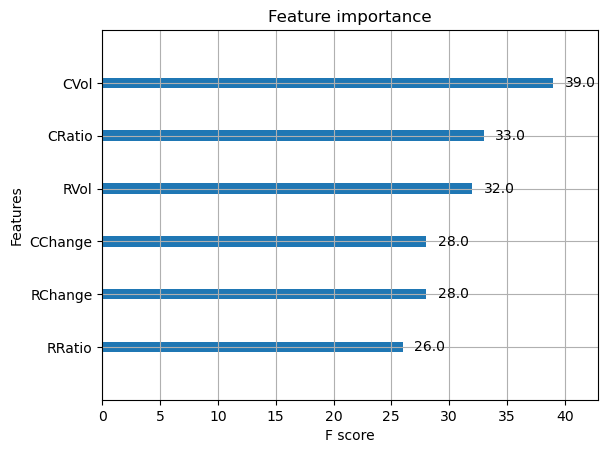

In [95]:
plot_importance(xgb_cv.best_estimator_)